# Introduction and Usage Guidelines

This notebook is designed as a base for analysis for Trackmania's physics. 

I'm running a small web server that collects and distributes collected map data from users using the Gigachad Collector plugin. 

(The 'in' section of the API is used by the GigaChad Collector (GCC) from within Trackmania.)

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# optional - makes plots pop out. highly recommended. disabled for rendering in git
#%matplotlib qt

# no trailing slash
url_prod = "http://gigachad.justinjschmitz.com:21532";
url_dev = "http://localhost:8080";

SERVER_PATH = url_prod

SWAGGER_PATH = f"{SERVER_PATH}/swagger-ui/index.html"

print(f"Current documentation page: {SWAGGER_PATH}")


Current documentation page: http://gigachad.justinjschmitz.com:21532/swagger-ui/index.html


## Data Selection

### "Maptags" vs "Runkeys" 

This is kind of an arbitrary convention, but:
* Map tags are for general surface use. 
* Runkeys are for specific study use. 

E.g., if you wanted to just look at how the stadium car drives on dirt, then you can pull the map tag 'stadium - dirt' and you'll have all that data. 

But, if you were doing some novel study (like trying to 2 wheel the rally car, or something) and wanted *just* that data, then make sure you set that as the the underlying runkey. That way, you're not pulling in more than you need to. 



In [2]:
maptags = requests.get(f"{SERVER_PATH}/out/maptag")
runkeys = requests.get(f"{SERVER_PATH}/out/runkey")
maptags_df = pd.json_normalize(maptags.json())
runkeys_df = pd.json_normalize(runkeys.json())
display(maptags_df)
display(runkeys_df)

# change these values with 'tag' and 'name' respectively

# 'legacy' for all of my old training data 
# these frames can be hard to work with
SELECTED_MAPTAG = 'legacy' 
SELECTED_RUNKEY = 'legacy'


,mtId,mapUuid,tag,username
0,2,bu5OUM_XDFQ7w_vnhQOopNsyJQ8,dirt - stadium,sgt_bigbird
1,3,nDqOzuoWkPUJ9m74q0ihDVlTFn7,dirt - snow,sgt_bigbird
2,4,OuHxc71KtYLTkb7r6AmJcHCbbz8,dirt - rally,sgt_bigbird
3,5,M92iB3BWeAsGChHVL6QqqtAnNC6,dirt - desert,sgt_bigbird
4,6,LEGACY,legacy,sgt_bigbird


,rkId,name,mode
0,102,default,1
1,103,legacy,1


In [3]:
# For 'maptag' data:
maptag_data = requests.get(f"{SERVER_PATH}/out/data/tag", params={"tag": SELECTED_MAPTAG})
# For 'runkey' data:
runkey_data = requests.get(f"{SERVER_PATH}/out/data/runkey", params={"runkey": SELECTED_RUNKEY})

# For all available data:
all_data = requests.get(f"{SERVER_PATH}/out/all", params={"runkey": SELECTED_RUNKEY})

# Some columns are hidden from these views to save data. If you want them, add "/verbose" to the end of the route. 
# Same for the 'all data' route. 

print(f"Loaded {len(maptag_data.text)} chars of maptag data, {len(runkey_data.text)} chars of runkey data")

Loaded 140124821 chars of maptag data, 140124821 chars of runkey data


In [4]:
# data = maptag_data
data = runkey_data
# data = all_data

['XXX_Null' 'Wood' 'RoadIce' 'Water' 'Concrete' 'Green']


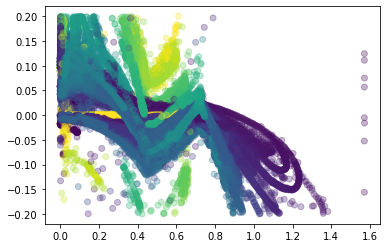

In [5]:
df = pd.json_normalize(data.json())

# Example: Graph of acceleration at different slide angles

## Preprocess: 

# Acceleration isn't natively provided - do .diff() for this and any other derivatives you want to calculate
# You can do a rolling average, too, depending on usage
df["acc"] = df["speed"].diff()

## Filter:

df = df[abs(df["acc"]) < 0.2]

# Use this type of call to see what surfaces are available
# Legacy is mostly wood - I have more data in .csv format, but haven't uploaded it yet

# print(df["frGroundContactMaterial"].unique())

df = df[df["flGroundContactMaterial"] == "Wood"]
df = df[df["frGroundContactMaterial"] == "Wood"]
df = df[df["rlGroundContactMaterial"] == "Wood"]
df = df[df["rrGroundContactMaterial"] == "Wood"]

## Now scatter the data 
plt.scatter(x=df["slipDir"], y=df["acc"], c=df["speed"], alpha=0.3)
plt.show()